In [205]:
import numpy as np
import astropy
import astropy.coordinates as ac
import astropy.units as u
import astropy.io
import astropy.table
import scipy
import pandas as pd
import galstreams
import gcutils
import gala
import gala.coordinates as gc
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
lono,lato,lonf,latf,ro,rf,width=scipy.genfromtxt(lib_end_points_filen,usecols=(3-1,4-1,5-1,6-1,8-1,9-1,10-1),unpack=True)
name,sname,cootype=scipy.genfromtxt(lib_end_points_filen,usecols=(1-1,2-1,7-1),unpack=True,dtype=str)
azs,lats,azcenter,latcenter=gcutils.get_gc_for_pair(lono[i],lato[i],lonf[i],latf[i],degree=True,step=gcstep,dlat=width[i])


Tracks init by end points
==========================

In [154]:
tpair = astropy.io.ascii.read("lib_by_pair.dat",header_start=4)
#tpair.replace_column('Ro', tpair["Ro"].astype(float))
tpair

Name,ShortName,lono,lato,lonf,latf,frame,Ro,Rf,Width,Reference
str11,str5,float64,float64,float64,float64,str3,float64,float64,float64,str26
Phoenix,Phe,20.0,-57.0,27.0,-45.0,equ,17.5,17.5,0.18,Balbinot2016
Acheron,Ach,230.0,-2.0,259.0,21.0,equ,3.5,3.8,0.9,Grillmair2009
Cocytos,Coc,186.0,-3.0,259.0,20.0,equ,11.0,11.0,0.7,Grillmair2009
Lethe,Let,171.0,18.0,258.0,20.0,equ,13.0,13.0,0.4,Grillmair2009
Styx,Sty,194.0,20.0,259.0,21.0,equ,45.0,45.0,3.3,Grillmair2009
ACS,ACS,126.4,-0.7,133.9,64.2,equ,8.9,8.9,5.0,Grillmair2006
Pal15,Pal15,254.8,-0.12,255.3,-1.47,equ,38.4,38.4,0.0,Myeong2017
Eridanus,Eri,65.98,-21.42,66.4,-20.96,equ,95.0,95.0,0.0,Myeong2017
TucanaIII,Tuc3,-6.3,-59.7,3.2,-59.4,equ,23.0,27.0,0.18,"Shipp2018,DrlicaWagner2015"


In [552]:
gcstep=0.1
coo_frame=dict(equ="icrs",gal="galactic",Galactocentric="GC")

for i in range(tpair["lono"].size)[:]:
    
    #Generate track from end-points
    azs,lats,azcenter,latcenter=gcutils.get_gc_for_pair(tpair["lono"][i],tpair["lato"][i],tpair["lonf"][i],tpair["latf"][i],
                                                        degree=True,step=gcstep,dlat=0.)
    #Validate
    azs=np.round(azs,decimals=2)

    #If a detailed track is lacking and only Ro,Rf are reported, nothing better to do than linear interpolation
    Fd = scipy.interpolate.interp1d([tpair["lono"][i],tpair["lonf"][i]],[tpair["Ro"][i],tpair["Rf"][i]],bounds_error=False)
    distance = Fd(azs)
    
    #Astropy coords
    coo = ac.SkyCoord( azs*u.deg, lats*u.deg, frame=coo_frame[tpair["frame"][i]], distance = distance*u.kpc )
    coo.width = tpair["Width"][i]*np.ones_like(azs)*u.kpc 
        
    #Print track
    ofilen="track.ep.{Name}.{Ref}.ecsv".format(Name=tpair["Name"][i], Ref=tpair["Reference"][i].lower() )
    print("{N} {Name} -> {ofn}".format(N=i, Name=tpair["Name"][i], ofn=ofilen))
    #as magic ECSV
    t = astropy.table.QTable([coo.galactic,coo.width], names=['sc', 'width'])
    #t = astropy.table.QTable([coo.galactic], names=['sc'])
    astropy.io.ascii.write(t, format='ecsv', output=ofilen, overwrite='True')   
    

0 Phoenix -> track.ep.Phoenix.balbinot2016.ecsv
1 Acheron -> track.ep.Acheron.grillmair2009.ecsv
2 Cocytos -> track.ep.Cocytos.grillmair2009.ecsv
3 Lethe -> track.ep.Lethe.grillmair2009.ecsv
4 Styx -> track.ep.Styx.grillmair2009.ecsv
5 ACS -> track.ep.ACS.grillmair2006.ecsv
6 Pal15 -> track.ep.Pal15.myeong2017.ecsv
7 Eridanus -> track.ep.Eridanus.myeong2017.ecsv
8 TucanaIII -> track.ep.TucanaIII.shipp2018,drlicawagner2015.ecsv
9 Indus -> track.ep.Indus.shipp2018.ecsv
10 Jhelum -> track.ep.Jhelum.shipp2018.ecsv
11 Ravi -> track.ep.Ravi.shipp2018.ecsv
12 Chenab -> track.ep.Chenab.shipp2018.ecsv
13 Elqui -> track.ep.Elqui.shipp2018.ecsv
14 Aliqa_Uma -> track.ep.Aliqa_Uma.shipp2018.ecsv
15 Turbio -> track.ep.Turbio.shipp2018.ecsv
16 Willka_Yaku -> track.ep.Willka_Yaku.shipp2018.ecsv
17 Turranburra -> track.ep.Turranburra.shipp2018.ecsv
18 Wambelong -> track.ep.Wambelong.shipp2018.ecsv
19 Palca -> track.ep.Palca.shipp2018.ecsv
20 Jet -> track.ep.Jet.jethwa2017.ecsv
21 Gaia-1 -> track.ep.Gai

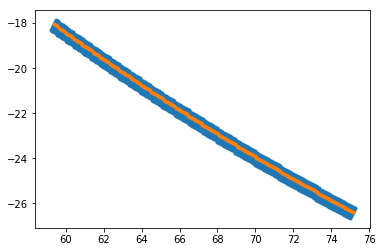

In [158]:
#Read-in validation
ofilen="track.ep.Turranburra.shipp2018.ecsv"
rr=astropy.io.ascii.read(ofilen, format='ecsv')   
#rr["sc"].ra
plt.plot(mwsts["Turranburra"].ra,mwsts["Turranburra"].dec,'.')
plt.plot(rr["sc"].icrs.ra.deg,rr["sc"].icrs.dec.deg,'.')

Tracks init by pole
====================

In [159]:
tpoles = astropy.io.ascii.read("lib_by_pole.dat",header_start=2)
tpoles

Name,pole_lon,pole_lat,pole_frame,center_lon,center_lat,cent_frame,dlon_deg,dlat,Ro,Rf,Reference
str9,float64,float64,str3,float64,float64,str3,float64,float64,float64,float64,str13
PS1-A,300.856,20.732,equ,160.17,-62.27,gal,5.0,0.45,7.9,7.9,Bernard2016
PS1-B,65.603,32.567,equ,248.41,32.3,gal,10.0,0.45,14.5,14.5,Bernard2016
PS1-C,232.227,33.838,equ,75.12,-32.6,gal,8.0,0.333,17.4,17.4,Bernard2016
PS1-D,49.64,2.467,equ,231.06,32.83,gal,45.0,0.867,22.9,22.9,Bernard2016
PS1-E,42.526,23.987,equ,144.17,58.4,gal,25.0,0.617,12.6,12.6,Bernard2016
ATLAS,77.16,46.92,equ,25.0,-30.0,equ,12.0,0.25,20.0,20.0,Koposov2014
Ophiuchus,184.32,77.25,equ,4.53,31.69,gal,2.5,0.12,9.5,9.5,Bernard2014
Sangarius,178.0,-52.0,gal,149.01,7.847,equ,59.0,0.44,21.0,21.0,Grillmair2017
Scamander,196.0,-41.0,gal,153.52,12.46,equ,66.0,0.22,21.0,21.0,Grillmair2017


In [553]:
tp=tpoles
for i in range(tp["Name"].size)[:]:
    _ = ac.galactocentric_frame_defaults.set('v4.0') 
    
    #Store pole and center coords, each in its own frame. 
    if "GC" not in tp["pole_frame"][i] and "GC" not in tp["cent_frame"][i]:
        pole_sc = ac.SkyCoord( tp["pole_lon"][i], tp["pole_lat"][i], unit=u.deg, frame=coo_frame[tp["pole_frame"][i]] )
        cent_sc = ac.SkyCoord( tp["center_lon"][i], tp["center_lat"][i], unit=u.deg, frame=coo_frame[tp["cent_frame"][i]] )
                             
        #Generate track from pole. Starting here, do everything in galactic
        azs,lats=gcutils.get_gc_for_pole(pole_sc.galactic.l.deg,pole_sc.galactic.b.deg,degree=True,
                                         center=[cent_sc.galactic.l.deg,cent_sc.galactic.b.deg],
                                         dlon=tp["dlon_deg"][i],dlat=0.,step=gcstep)
                                                                       
        distance = np.ones_like(azs)*tp["Ro"][i]                                                            
        coo = ac.SkyCoord( azs*u.deg, lats*u.deg, frame="galactic", distance = distance*u.kpc )
    else:
        if "GC" not in tp["cent_frame"][i]:
                cent_sc=ac.SkyCoord(tp["center_lon"][i]*u.deg, tp["center_lat"][i]*u.deg, frame=coo_frame[tp["cent_frame"][i]], 
                                    distance=tp["Ro"][i]*u.kpc)
                cent_in_GC=cent_sc.transform_to(ac.Galactocentric)                 
        azs,lats=gcutils.get_gc_for_pole( tp["pole_lon"][i],tp["pole_lat"][i],degree=True,
                                         center=[cent_in_GC.spherical.lon.deg,cent_in_GC.spherical.lat.deg],
                                         dlon=tp["dlon_deg"][i],dlat=0.,step=gcstep)
                                          
        distance=tp["Ro"][i]*np.ones_like(azs)                                                                     
        galcen = ac.SkyCoord(lon=azs*u.deg, lat=lats*u.deg, distance=distance*u.kpc, frame=ac.Galactocentric,  representation_type='spherical' )
        
        #Do it this way, instead of just gc.transform_to("galactic"), because extra info in SkyCoord obj due to Galactocentric initialization 
        #gives a RepresentationError when printing ecsv table
        coo = ac.SkyCoord(l=galcen.galactic.l, b=galcen.galactic.b, distance=galcen.galactic.distance, frame='galactic')                     

        
    width = tp["dlat"][i]*np.ones(np.size(coo.l))*u.kpc 
    
    
    #Print track
    print(tp["Name"][i],np.size(azs))
    ofilen="track.po.{Name}.{Ref}.ecsv".format(Name=tp["Name"][i], Ref=tp["Reference"][i].lower() )
    print("{N} {Name} -> {ofn}".format(N=i, Name=tp["Name"][i], ofn=ofilen))
    #as magic ECSV
    t = astropy.table.QTable([coo, width], names=['sc', 'width'])
    #t = astropy.table.QTable([coo], names=['sc'])

    astropy.io.ascii.write(t, format='ecsv', delimiter=',', output=ofilen, overwrite='True')   
    #print("printed")

PS1-A 50
0 PS1-A -> track.po.PS1-A.bernard2016.ecsv
PS1-B 100
1 PS1-B -> track.po.PS1-B.bernard2016.ecsv
PS1-C 80
2 PS1-C -> track.po.PS1-C.bernard2016.ecsv
PS1-D 450
3 PS1-D -> track.po.PS1-D.bernard2016.ecsv
PS1-E 250
4 PS1-E -> track.po.PS1-E.bernard2016.ecsv
ATLAS 120
5 ATLAS -> track.po.ATLAS.koposov2014.ecsv
Ophiuchus 25
6 Ophiuchus -> track.po.Ophiuchus.bernard2014.ecsv
Sangarius 502
7 Sangarius -> track.po.Sangarius.grillmair2017.ecsv
Scamander 653
8 Scamander -> track.po.Scamander.grillmair2017.ecsv
Corvus 3600
9 Corvus -> track.po.Corvus.mateu2018.ecsv


Individually initialized tracks
===================================

Ibata 2020 streams
------------------

In [266]:
ibt=astropy.io.ascii.read("../support_data/tab01_toCecilia.cat")
ib=ac.SkyCoord(ra=ibt["ra_epoch2000"]*u.deg, dec=ibt["dec_epoch2000"]*u.deg, distance=ibt["dis"]*u.kpc, 
                pm_ra_cosdec=ibt["pmra"]*u.mas/u.yr, pm_dec=ibt["pmdec"]*u.mas/u.yr , radial_velocity=np.zeros(ibt["dis"].size)*u.km/u.s)
ib.stream=ibt["stream"]

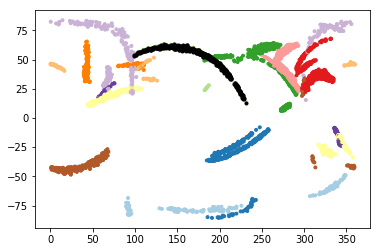

In [241]:
m=ib.stream==8
plt.scatter(ib.galactic.l,ib.galactic.b,c=ib.stream,marker='.',cmap=plt.cm.Paired)
plt.plot(ib.galactic.l[m],ib.galactic.b[m],'.k')

In [242]:
ib[m][-3]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (218.8535533, 58.7747837, 11.9)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-6.83, -1.416, 0.)>

In [269]:
#pole=gc.greatcircle.pole_from_endpoints(ib[m][0], ib[m][-3])

In [282]:
#np.unique(ib.stream)

In [292]:
for ss in np.unique(ib.stream):
    m=ib.stream==ss
    if m.sum()<2: 
        print(f"WARNING: Stream {ss} <2 points")
        continue
    #It has to be done this way. I dont't know why, but using the full ib SKyCoord obj gives a representation error
    #TypeError: Operation 'truediv' is not supported when differentials are attached to a CartesianRepresentation.    
    aux=ac.SkyCoord(ra=ib[m][[5,-5]].ra.value,dec=ib[m][[5,-5]].dec.value,unit=u.deg)
    fr = gc.GreatCircleICRSFrame.from_endpoints(aux[0],aux[1])
    ibp = ib.transform_to(fr)

    print(f"Stream {ss} |phi2_max|={np.max(np.abs(ibp[m].phi2.value))}")

Stream 1 |phi2_max|=2.4276902061355523
Stream 2 |phi2_max|=1.321440108500218
Stream 3 |phi2_max|=5.025452862423475
Stream 4 |phi2_max|=1.0114128539804563
Stream 5 |phi2_max|=2.5066395080116624
Stream 6 |phi2_max|=2.4463423784077056
Stream 7 |phi2_max|=0.28572085031459654
Stream 8 |phi2_max|=6.272124187519273
Stream 9 |phi2_max|=2.3254834829148985
Stream 10 |phi2_max|=2.4087426331538273
Stream 11 |phi2_max|=7.478861471572001
Stream 12 |phi2_max|=4.187286184240396
Stream 13 |phi2_max|=2.4803377666758073
Stream 14 |phi2_max|=1.8782649370652913
Stream 15 |phi2_max|=1.5548180901977138
Stream 16 |phi2_max|=12.272020159604565
Stream 17 |phi2_max|=1.5780096627500109
Stream 18 |phi2_max|=0.8908820625912087
Stream 19 |phi2_max|=2.2545364923574094
Stream 20 |phi2_max|=3.125671078439169
Stream 21 |phi2_max|=4.270503424687459
Stream 22 |phi2_max|=15.730868737863036
Stream 23 |phi2_max|=1.2315068207631215
Stream 24 |phi2_max|=5.987634184990346
Stream 25 |phi2_max|=0.7831977133287966
Stream 26 |phi2_

In [369]:
def mean_of_skycoords(coo):
    sum_coo = ac.SkyCoord(x=np.sum(coo.cartesian.x),
                          y=np.sum(coo.cartesian.y),
                          z=np.sum(coo.cartesian.z),
                          frame=ac.ICRS, representation_type='cartesian')
    #Surely there's a more elegant way of doing this. No patience right now. This is pretty clearly right.
    sum_coo = ac.SkyCoord(ra=sum_coo.spherical.lon, dec=sum_coo.spherical.lat)
    #sum_coo = sum_coo.unitspherical ?
    
    return sum_coo

Text(0, 0.5, 'DEC')

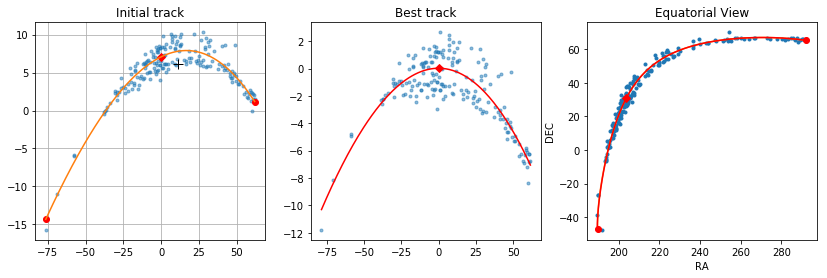

In [475]:
m = ib.stream==22 #22 #31
#It has to be done this way. I dont't know why, but using the full ib SKyCoord obj gives a representation error
#TypeError: Operation 'truediv' is not supported when differentials are attached to a CartesianRepresentation.

plt.figure(1,figsize=(14,4))

aux = ac.SkyCoord(ra=ib[m][[5,-5]].ra.value,dec=ib[m][[5,-5]].dec.value,unit=u.deg)
#find mean
center=mean_of_skycoords(ib[m])

pole = gc.greatcircle.pole_from_endpoints(aux[0],aux[1])
fr = gc.GreatCircleICRSFrame(pole=pole,ra0=center.ra)
ibp = ib.transform_to(fr)

plt.subplot(131)
plt.plot(ibp[m].phi1,ibp[m].phi2,'.',alpha=0.5)
plt.plot(center.transform_to(fr).phi1, center.transform_to(fr).phi2, 'k+',ms=10)

phi1s = np.linspace(np.min(ibp[m].phi1),np.max(ibp[m].phi1),200)
phi2fit = np.poly1d(np.polyfit(ibp[m].phi1.deg,ibp[m].phi2.deg, deg=3))

phi1_end_points = phi1s[[0,-1]]
track_end_points = gc.GreatCircleICRSFrame(phi1=phi1_end_points,
                                           phi2=phi2fit(phi1_end_points.value)*u.deg,
                                           pole=pole, ra0=center.ra)
track_mid_point =  gc.GreatCircleICRSFrame(phi1=0.*u.deg,
                                           phi2=phi2fit(0.)*u.deg,
                                           pole=pole, ra0=center.ra)

plt.plot(track_mid_point.phi1,track_mid_point.phi2,'rD')
plt.plot(track_end_points.phi1,track_end_points.phi2,'ro')


#Track object
track = gc.GreatCircleICRSFrame(phi1=phi1s, phi2=phi2fit(phi1s.value)*u.deg, pole=pole, ra0=center.ra)
plt.plot(track.phi1,track.phi2,'-')
#plt.ylim(-10,10)
plt.title("Initial track") 
plt.grid()

#Recompute the track using the newly determined end points
#track_end_points=track_end_points.transform_to(ac.ICRS)
two_points_near_mid = gc.GreatCircleICRSFrame(phi1=[-0.5,0.5]*u.deg, phi2=phi2fit([-0.5,0.5])*u.deg, pole=pole, ra0=center.ra)
aux=ac.SkyCoord(ra=two_points_near_mid.transform_to(ac.ICRS).ra.value, dec=two_points_near_mid.transform_to(ac.ICRS).dec.value, unit=u.deg)
new_pole = gc.greatcircle.pole_from_endpoints(aux[0],aux[1])
newfr = gc.GreatCircleICRSFrame(pole=new_pole, ra0=track_mid_point.transform_to(ac.ICRS).ra)
ibp = ib.transform_to(newfr)

phi1s = np.linspace(np.min(ibp[m].phi1),np.max(ibp[m].phi1),200)
phi2fit = np.poly1d(np.polyfit(ibp[m].phi1.deg,ibp[m].phi2.deg, deg=3))
newtrack = gc.GreatCircleICRSFrame(phi1=phi1s, phi2=phi2fit(phi1s.value)*u.deg, 
                                   pole=new_pole, ra0=track_mid_point.transform_to(ac.ICRS).ra)

#COnclusion: I only need to compute the new pole. The track will be the same.

plt.subplot(132)
plt.plot(ibp[m].phi1,ibp[m].phi2,'.',alpha=0.5)
#plt.plot(center.transform_to(newfr).phi1,center.transform_to(newfr).phi2,'r+')
plt.plot(newtrack.phi1,newtrack.phi2,'r-')
plt.plot(track_mid_point.transform_to(newfr).phi1,track_mid_point.transform_to(newfr).phi2,'rD')
#plt.plot(track_end_points.transform_to(newfr).phi1,track_end_points.transform_to(newfr).phi2,'ro')
#plt.ylim(-10,10)
plt.title("Best track")                     

#ra-dec plot
plt.subplot(133)
plt.plot(ib[m].ra,ib[m].dec,'.')
plt.plot(track.transform_to(ac.ICRS).ra,track.transform_to(ac.ICRS).dec)
plt.plot(track_mid_point.transform_to(ac.ICRS).ra.deg,track_mid_point.transform_to(ac.ICRS).dec.deg,'rD')
plt.plot(track_end_points.transform_to(ac.ICRS).ra.deg,track_end_points.transform_to(ac.ICRS).dec.deg,'ro')
plt.plot(newtrack.transform_to(ac.ICRS).ra,newtrack.transform_to(ac.ICRS).dec,'r-')
plt.title("Equatorial View")
plt.xlabel("RA")
plt.ylabel("DEC")

In [ ]:
#     def scfit(sc, frame, phi2fit_obj):
#         phi2 = phi2fit_obj(sc.transform_to(frame).phi1.deg)
#         return ac.SkyCoord(phi1=sc.transform_to(new_fr).phi1, phi2=phi2*u.deg, frame=frame)

In [715]:
def get_track_from_points(sc, N=200, deg=3):
    """ Estimate the mean track from a set of stream stars or points 

        Parameters
        ----------
        sc : `astropy.coordinates.SkyCoord` instance 

    """
    
    
    #find mean
    center=mean_of_skycoords(sc)
    #to get the extremes I should wrap the angles at the center and then get min/max. this is general
    aux = ac.SkyCoord(ra=sc[[5,-5]].ra.value,dec=sc[[5,-5]].dec.value,unit=u.deg)
    
    
    pole = gc.greatcircle.pole_from_endpoints(aux[0],aux[1])
    fr = gc.GreatCircleICRSFrame(pole=pole,ra0=center.ra)
    scp = sc.transform_to(fr)

    
    phi1s = np.linspace(np.min(scp.phi1),np.max(scp.phi1),N)
    phi2fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.phi2.deg, deg=deg))

    phi1_end_points = phi1s[[0,-1]]
    
#     track_end_points = ac.SkyCoord(phi1= phi1_end_points, phi2=phi2fit(phi1_end_points.value)*u.deg,
#                                    frame=fr)
    track_mid_point = ac.SkyCoord(phi1=0.*u.deg, phi2=phi2fit(0.)*u.deg,
                                   frame=fr)
    
    #Initial track object
    track = ac.SkyCoord(phi1=phi1s, phi2=phi2fit(phi1s.value)*u.deg, frame=fr)

    #Recompute the track using two points in the track, close to the center, at both sides
    #track_end_points=track_end_points.transform_to(ac.ICRS)
    #two_points_near_mid = gc.GreatCircleICRSFrame(phi1=[-0.5,0.5]*u.deg, phi2=phi2fit([-0.5,0.5])*u.deg, pole=pole, ra0=center.ra)
    two_points_near_mid = ac.SkyCoord(phi1=[-0.5,0.5]*u.deg, phi2=phi2fit([-0.5,0.5])*u.deg, frame=fr)
    aux=ac.SkyCoord(ra=two_points_near_mid.transform_to(ac.ICRS).ra.value, dec=two_points_near_mid.transform_to(ac.ICRS).dec.value, unit=u.deg)
    new_pole = gc.greatcircle.pole_from_endpoints(aux[0],aux[1])
    
    #New stream's frame -------------------------------------------------------------------
    new_fr = gc.GreatCircleICRSFrame(pole=new_pole, ra0=track_mid_point.transform_to(ac.ICRS).ra)
    scp = sc.transform_to(new_fr)

    phi1s = np.linspace(np.min(scp.phi1),np.max(scp.phi1),N)
    phi1_end_points = phi1s[[0,-1]]
    
    #Set up polynomial fit with explicit frame so it can take a SkyCoord object in any frame and do it's magic
    phi2_fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.phi2.value, deg=deg))
    phi2_track = phi2_fit(phi1s.deg)*scp.phi2.unit
    phi2_end = phi2_track[[0,-1]]
    phi2_mid = phi2_fit([0.,])*scp.phi2.unit
    
    #Distance track
    if hasattr(scp, 'distance'):
        dist_fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.distance.kpc, deg=deg))
        distance_track=dist_fit(phi1s.deg)*scp.distance.unit
        distance_mid = dist_fit([0.,])*u.kpc
        distance_end = dist_fit(phi1_end_points.deg)*scp.distance.unit 
    else:
        dist_fit, distance_track, distance_mid, distance_end = None, None, None, None
    
    #Width track
    width = np.std(scp.phi2)*np.ones(scp.phi2.size)
    
    #Proper motion tracks
    if hasattr(scp, 'pm_phi1_cosphi2'):
        pm1_fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.pm_phi1_cosphi2.value, deg=deg)) 
        pm1_track = pm1_fit(phi1s.deg)*scp.pm_phi1_cosphi2.unit
        pm1_mid, pm1_end = pm1_fit([0.,])*scp.pm_phi1_cosphi2.unit, pm1_fit(phi1_end_points.deg)*scp.pm_phi1_cosphi2.unit
    else:
        pm1_fit, pm1_track, pm1_mid, pm1_end  = None, None, None, None
        
    if hasattr(scp, 'pm_phi2'):  
       pm2_fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.pm_phi2.value, deg=deg)) 
       pm2_track = pm2_fit(phi1s.deg)*scp.pm_phi2.unit
       pm2_mid, pm2_end = pm2_fit([0.,])*scp.pm_phi2.unit, pm2_fit(phi1_end_points.deg)*scp.pm_phi2.unit
    else:
        pm2_fit, pm2_track, pm2_mid, pm2_end = None, None, None, None
        
    if hasattr(scp, 'radial_velocity'):
        vrad_fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.radial_velocity.value, deg=deg))  
        vrad_track =  vrad_fit(phi1s.deg)*scp.radial_velocity.unit
        vrad_mid, vrad_end = vrad_fit([0.,])*scp.radial_velocity.unit, vrad_fit(phi1_end_points.deg)*scp.radial_velocity.unit
    else: 
        vrad_fit, vrad_track, vrad_mid, vrad_end = None, None, None, None
        
    #Store interpolator objs
    fits = dict(phi2=phi2_fit, dist=dist_fit, pm1cosphi2=pm1_fit, pm2=pm2_fit, vrad=vrad_fit)
        
    #Final track object
    newtrack = ac.SkyCoord(phi1 = phi1s, 
                           phi2 = phi2_track, 
                           distance = distance_track,
                           pm_phi1_cosphi2 = pm1_track,
                           pm_phi2 = pm2_track,
                           radial_velocity = vrad_track,
                           frame = new_fr)
    #Add width attribute
    newtrack.width=width
    
    #Mid and end points
    track_end_points = ac.SkyCoord(phi1= phi1_end_points, phi2=phi2_end,
                                   distance=distance_end,  pm_phi1_cosphi2=pm1_end, pm_phi2=pm2_end, radial_velocity=vrad_end,
                                   frame=new_fr)
    track_mid_point = ac.SkyCoord(phi1=0.*u.deg, phi2=phi2_mid,
                                  distance=distance_mid,  pm_phi1_cosphi2=pm1_mid, pm_phi2=pm2_mid, 
                                  #radial_velocity=vrad_mid,
                                  frame=new_fr)
#     track_mid_point = ac.SkyCoord(phi1=0.*u.deg, phi2=phi2_mid, distance=distance_mid,
#                                        frame=new_fr)
 

    
    return (newtrack.transform_to(ac.ICRS), track_end_points.transform_to(ac.ICRS), track_mid_point.transform_to(ac.ICRS), 
            new_pole.transform_to(ac.ICRS), new_fr, fits)


In [716]:
def stream_id_card(sc, stream_fr, axs, plotkwds={}, show_labels=False, show_grid=False):

    

    labels1=dict(phi2="$\phi_2$ ($\degree$)", distance="$D$ (kpc)", 
                 pm_phi1_cosphi2="$\mu\phi1$ (arcsec/yr)", pm_phi2="$\mu\phi2$ (arcsec/yr)",
                 radial_velocity="$v_r$ (km/s)")
    labels2=dict(ra="$\\alpha$ ($\degree$)",dec="$\delta$ ($\degree$)", distance="$D$ (kpc)", 
                 pm_ra_cosdec="$\mu\alpha$ (arcsec/yr)", pm_dec="$\mu\delta$ (arcsec/yr)",
                 radial_velocity="$v_r$ (km/s)")
    
    #Plots in stream frame coords    
    r,c=0,0    
    for att in ["phi2","distance", "pm_phi1_cosphi2", "pm_phi2",  "radial_velocity"]:
        if hasattr(sc.transform_to(stream_fr), att): 
            axs[r,c].plot(sc.transform_to(stream_fr).phi1, getattr(sc.transform_to(stream_fr),att), **plotkwds)
        if show_grid: axs[r,c].grid()
        if show_labels:
            if axs[r,c].is_last_row(): axs[r,c].set_xlabel("$\phi_1$ ($\degree$)")
            axs[r,c].set_ylabel(labels1[att])
        r=r+1

    #Plots in equatorial coords
    r,c=0,1  
    for att in ["dec","distance", "pm_ra_cosdec", "pm_dec",  "radial_velocity"]:
        if hasattr(sc.icrs, att): 
            axs[r,c].plot(sc.icrs.ra, getattr(sc.icrs,att), **plotkwds)
        if show_grid: axs[r,c].grid()
        if show_labels:
            if axs[r,c].is_last_row(): axs[r,c].set_xlabel("$\\alpha$ ($\degree$)")
            axs[r,c].set_ylabel(labels2[att])
        r=r+1
    
    #return f, axs

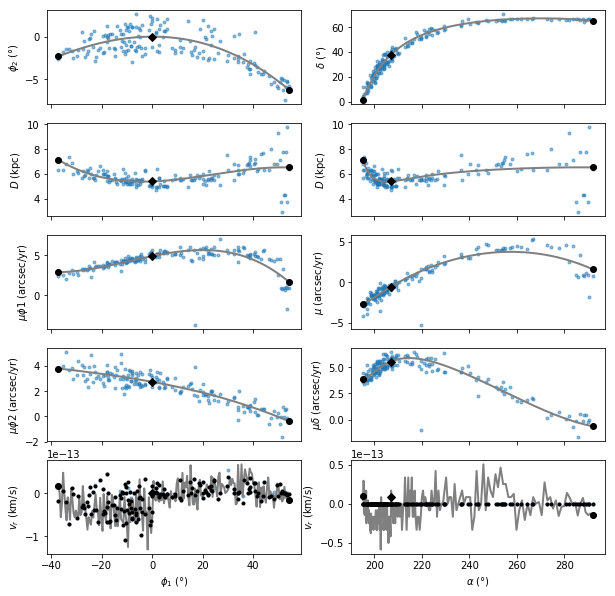

In [717]:
m = ib.stream==22 #22 #31
#It has to be done this way. I dont't know why, but using the full ib SKyCoord obj gives a representation error
#TypeError: Operation 'truediv' is not supported when differentials are attached to a CartesianRepresentation.
mask = ib.ra>195*u.deg
ibs = ib[m & mask]
#ibs = ib[m]

track, track_end_points, track_mid_point, new_pole, stream_fr, phi2_interp = get_track_from_points(ibs)

#test = ac.SkyCoord(track.transform_to(stream_fr).phi1, track.transform_to(stream_fr).phi2, frame=stream_fr)

pkwds=dict(marker='.',ls='', alpha=0.5)
tkwds=dict(marker='',ls='-', lw=2, color='gray')
mkw=dict(marker='D',ls='', color='k')
ekw=dict(marker='o',ls='', color='k')
figkwds=dict(num=1,figsize=(10,10))

nx, ny = 2, 5
fig=plt.figure(1,figsize=(10,10))
axs = fig.subplots(ny,nx, sharex="col")

stream_id_card(ibs, stream_fr, axs, plotkwds=pkwds, show_labels=True)
stream_id_card(track, stream_fr, axs, plotkwds=tkwds)
stream_id_card(track_end_points, stream_fr, axs, plotkwds=ekw)
stream_id_card(track_mid_point, stream_fr, axs, plotkwds=mkw)


axs[4,0].plot(ibs.transform_to(stream_fr).phi1,ibs.transform_to(stream_fr).radial_velocity,'k.')
axs[4,1].plot(ibs.ra,ibs.radial_velocity,'k.')


# ofilen="track.{Name}.{Ref}.ecsv".format(Name=tp["Name"][i], Ref=tp["Reference"][i].lower() )
# print("{N} {Name} -> {ofn}".format(N=i, Name=tp["Name"][i], ofn=ofilen))
# #as magic ECSV
# t = astropy.table.QTable([coo, width], names=['sc', 'width'])
# #t = astropy.table.QTable([coo], names=['sc'])

# astropy.io.ascii.write(t, format='ecsv', delimiter=',', output=ofilen, overwrite='True')   



In [672]:
ibs.radial_velocity.min(),ibs.radial_velocity.max()

(<Quantity 0. km / s>, <Quantity 0. km / s>)

In [628]:
#ibs.icrs.pm_ra_cosdec

In [534]:
ibs.radial_velocity=ibs.ra

AttributeError: Cannot set any frame attribute radial_velocity

Extras - Tests - Misc
=============================

In [141]:
t["sc"].b.deg

array([-46.14275137, -46.1483367 , -46.15392221, ..., -46.12599641,
       -46.13158122, -46.13716621])

In [109]:
cc=ac.SkyCoord(60.*u.deg, 9.145*u.deg, distance=1*u.kpc, frame=ac.Galactocentric, representation_type='spherical')

In [165]:
#ac.galactocentric_frame_defaults.set('v4.0') 
with ac.galactocentric_frame_defaults.set('v4.0'):
    print(ac.Galactocentric()) 

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>


In [110]:
cc.cartesian.x, np.cos(cc.spherical.)

<Quantity 0.49364464 kpc>

Tests
======

In [6]:
track = [[-15.565,   9.145],
             [-14.881,   9.873],
             [-14.537,  10.957],
             [-13.731,  11.824],
             [-13.373,  12.646],
             [-12.198,  14.068],
             [-11.59 ,  15.172],
             [-10.808,  16.029],
             [-10.176,  16.871],
             [ -9.805,  17.428]]
track = np.array(track)
t = ac.SkyCoord(ra=track[:,0]*u.deg,dec=track[:,1]*u.deg,frame='icrs')


In [16]:
azs,lats,azcenter,latcenter=gcutils.get_gc_for_pair(-6.3, -59.7,    3.2,  -59.4,degree=True,step=gcstep,dlat=0.)


In [17]:
mwsts=galstreams.MWStreams(verbose=False)

/Users/cmateu/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


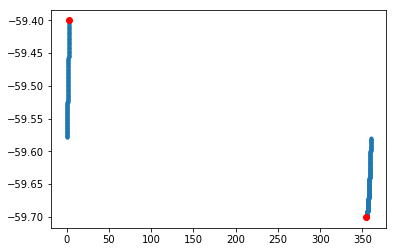

In [24]:
plt.plot(azs,lats,'.')
ii=8
plt.plot(360+tpair["lono"][ii],tpair["lato"][ii],'ro')
plt.plot(tpair["lonf"][ii],tpair["latf"][ii],'ro')
#plt.plot(coo.galactic.l.deg,coo.galactic.b.deg,'x',ms=1)

In [ ]:
plt.plot(coo.ra.deg,coo.dec.deg,'.')
plt.plot(coo.ra.deg,coo.dec.deg,'x')

In [70]:
c = ac.SkyCoord(ra=[-6.3,3.2],dec=[-59.7,-59.4],frame='icrs',unit=u.deg)
c.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    [(353.7, -59.7), (  3.2, -59.4)]>

In [26]:
azs[0],azs[-1],

(354.33, 354.31)

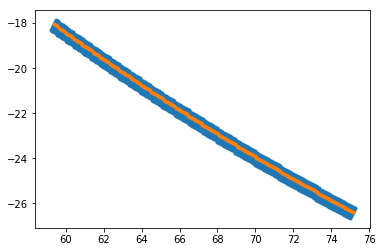

In [186]:
ofilen="track.ep.Turranburra.shipp2018.ecsv"
rr=astropy.io.ascii.read(ofilen, format='ecsv')   
#rr["sc"].ra
plt.plot(mwsts["Turranburra"].ra,mwsts["Turranburra"].dec,'.')
plt.plot(rr["sc"].icrs.ra.deg,rr["sc"].icrs.dec.deg,'.')

In [76]:
c = ac.SkyCoord(ra=-6.3*u.deg,dec=-59.7*u.deg,distance=10*u.kpc,frame='icrs')


<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in kpc
    (-3.94078643, -3.72526376, -8.1656827)>

In [79]:
c_gc=c.transform_to(ac.Galactocentric)
c_gc.spherical.lon

<Longitude 223.38961565 deg>

In [116]:
c_gc.galactic.l

<Longitude 319.65556147 deg>